📦 Cell 1: Install Dependencies

In [ ]:
# Install required packages
!pip install transformers datasets peft optuna rouge-score sqlglot matplotlib seaborn scikit-learn -q

📚 Cell 2: Import Libraries

In [ ]:
import os
import pandas as pd
import gc
import numpy as np
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import transformers
import time
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Trainer,
    TrainingArguments,
    GenerationConfig
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from sqlglot import parse_one, transpile
from google.colab import drive
import optuna
from optuna.samplers import TPESampler
from optuna.importance import get_param_importances
import json
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from pandas.plotting import parallel_coordinates
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


💾 Cell 3: Mount Drive & Setup Configurations

In [ ]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Memory optimization settings
if device == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.set_per_process_memory_fraction(0.90)  # Use 90% of GPU memory
    print("GPU memory optimization enabled")

# Paths Configuration
MODEL_NAME = "gaussalgo/T5-LM-Large-text2sql-spider"
TRAIN_DATA_PATH = "/content/drive/MyDrive/QueryHub_FineTuning/train.csv"
TEST_DATA_PATH = "/content/drive/MyDrive/QueryHub_FineTuning/test.csv"
VAL_DATA_PATH = "/content/drive/MyDrive/QueryHub_FineTuning/val.csv"

# Output Directories
BAYESIAN_OUTPUT_DIR = "/content/drive/MyDrive/QueryHub_FineTuning/bayesian_trials"
BEST_MODEL_DIR = "/content/drive/MyDrive/QueryHub_FineTuning/text2sql_lora_best"
PLOTS_DIR = "/content/drive/MyDrive/QueryHub_FineTuning/plots"

# Bayesian Optimization Settings
PROBE_EPOCHS = 1
FULL_EPOCHS = 4
MAX_TRIALS = 3

# Tokenization settings
max_source_length = 128
max_target_length = 128

# Create directories
os.makedirs(BAYESIAN_OUTPUT_DIR, exist_ok=True)
os.makedirs(BEST_MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Configuration complete!")

Using device: cuda
GPU memory optimization enabled
Configuration complete!


📊 Cell 4: Load and Sample Data

In [ ]:
print("Loading data...")
df_tr = pd.read_csv(TRAIN_DATA_PATH)
df_ts = pd.read_csv(TEST_DATA_PATH)
df_val = pd.read_csv(VAL_DATA_PATH)

print(f"Original sizes - Train: {len(df_tr)}, Val: {len(df_val)}, Test: {len(df_ts)}")

# CRITICAL: Reduce validation set for Bayesian optimization
# During probe (1 epoch), validation should be small to save memory
df_tr_sample = df_tr.sample(n=15000, random_state=42)
df_val_sample = df_val.sample(n=2000, random_state=42)  # ← REDUCED from 20000
df_ts_sample = df_ts.sample(n=2000, random_state=42)

print(f"\nSampled sizes:")
print(f"  Training: {len(df_tr_sample)}")
print(f"  Validation: {len(df_val_sample)} (reduced for Bayesian optimization)")
print(f"  Test: {len(df_ts_sample)}")

# Free memory
del df_tr, df_ts, df_val
gc.collect()

# Create Hugging Face datasets
dataset_tr = Dataset.from_pandas(df_tr_sample[["input_text", "sql"]])
dataset_ts = Dataset.from_pandas(df_ts_sample[["input_text", "sql"]])
dataset_val = Dataset.from_pandas(df_val_sample[["input_text", "sql"]])

print(f"\nDataset objects created successfully!")

Loading data...
Original sizes - Train: 284197, Val: 32348, Test: 5649

Sampled sizes:
  Training: 5000
  Validation: 2000 (reduced for Bayesian optimization)
  Test: 2000

Dataset objects created successfully!


🔧 Cell 5: Preprocessing Function

In [ ]:
# Load tokenizer for preprocessing
tokenizer_prep = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer_prep.truncation_side = "right"

def preprocess_batch(batch):
    """Tokenize input text and SQL queries"""
    inputs = batch["input_text"]
    targets = batch["sql"]

    # Tokenize inputs
    model_inputs = tokenizer_prep(
        inputs,
        max_length=max_source_length,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets
    with tokenizer_prep.as_target_tokenizer():
        labels = tokenizer_prep(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding="max_length"
        )

    # Replace padding token ids in labels by -100 (ignored in loss)
    labels_ids = labels["input_ids"]
    labels_ids = [
        [(token_id if token_id != tokenizer_prep.pad_token_id else -100)
         for token_id in seq]
        for seq in labels_ids
    ]
    model_inputs["labels"] = labels_ids

    return model_inputs

print("Preprocessing function defined!")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Preprocessing function defined!


🎯 Cell 6: Tokenize Datasets

In [ ]:
print("Tokenizing datasets...")

tokenized_train = dataset_tr.map(
    preprocess_batch,
    batched=True,
    remove_columns=dataset_tr.column_names,
    load_from_cache_file=True
)

tokenized_val = dataset_val.map(
    preprocess_batch,
    batched=True,
    remove_columns=dataset_val.column_names,
    load_from_cache_file=True
)

tokenized_test = dataset_ts.map(
    preprocess_batch,
    batched=True,
    remove_columns=dataset_ts.column_names,
    load_from_cache_file=True
)

print("✓ Tokenization complete!")
print(f"  Train: {len(tokenized_train)} samples")
print(f"  Val: {len(tokenized_val)} samples")
print(f"  Test: {len(tokenized_test)} samples")

Tokenizing datasets...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

✓ Tokenization complete!
  Train: 5000 samples
  Val: 2000 samples
  Test: 2000 samples


📏 Cell 7: Define Metric Functions

In [ ]:
def sql_tokenize(s):
    """Tokenize SQL query for F1 computation"""
    s = s.lower().strip()
    for tok in ["(", ")", ",", ";"]:
        s = s.replace(tok, f" {tok} ")
    return s.split()

def compute_exact_match(pred, gold):
    """Compute exact match between prediction and gold"""
    return 1.0 if pred.strip().lower() == gold.strip().lower() else 0.0

def compute_f1(pred, gold):
    """Compute token-level F1 score"""
    pred_tokens = sql_tokenize(pred)
    gold_tokens = sql_tokenize(gold)

    all_tokens = list(set(pred_tokens + gold_tokens))
    pred_vec = [1 if t in pred_tokens else 0 for t in all_tokens]
    gold_vec = [1 if t in gold_tokens else 0 for t in all_tokens]

    if sum(gold_vec) == 0:
        return 1.0

    return f1_score(gold_vec, pred_vec)

def compute_rouge_scores(pred, gold):
    """Compute ROUGE-2 and ROUGE-L scores"""
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(gold.lower().strip(), pred.lower().strip())

    return {
        'rouge2_precision': scores['rouge2'].precision,
        'rouge2_recall': scores['rouge2'].recall,
        'rouge2_fmeasure': scores['rouge2'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_fmeasure': scores['rougeL'].fmeasure,
    }

def compute_metrics(eval_pred):
    """Compute metrics during training"""
    predictions, labels = eval_pred

    # Handle chunked outputs
    if isinstance(predictions, (list, tuple)):
        if isinstance(predictions[0], (list, tuple)):
            predictions = [p[0] for p in predictions]
    else:
        predictions = [predictions]

    if isinstance(labels, (list, tuple)):
        labels = [l if isinstance(l, np.ndarray) else np.array(l) for l in labels]
    else:
        labels = [labels]

    all_exact_scores = []
    all_f1_scores = []

    for pred_chunk, label_chunk in zip(predictions, labels):
        # Greedy decode
        pred_ids = np.argmax(pred_chunk, axis=-1)
        decoded_preds_chunk = tokenizer_prep.batch_decode(pred_ids, skip_special_tokens=True)

        # Fix labels
        label_chunk = np.where(label_chunk != -100, label_chunk, tokenizer_prep.pad_token_id)
        decoded_labels_chunk = tokenizer_prep.batch_decode(label_chunk, skip_special_tokens=True)

        # Compute metrics
        chunk_exact = [compute_exact_match(p, l) for p, l in zip(decoded_preds_chunk, decoded_labels_chunk)]
        chunk_f1 = [compute_f1(p, l) for p, l in zip(decoded_preds_chunk, decoded_labels_chunk)]

        all_exact_scores.extend(chunk_exact)
        all_f1_scores.extend(chunk_f1)

    return {
        "exact_match": np.mean(all_exact_scores),
        "token_f1": np.mean(all_f1_scores)
    }

print("✓ Metric functions defined!")

✓ Metric functions defined!


📊 Cell 8: Define Visualization Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title, save_path):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Complexity', fontsize=12)
    plt.xlabel('Predicted Complexity', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

def plot_metrics_comparison(metrics_dict, title, save_path):
    """Plot comparison of different metrics"""
    metrics_names = list(metrics_dict.keys())
    metrics_values = list(metrics_dict.values())

    plt.figure(figsize=(12, 6))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']
    bars = plt.bar(metrics_names, metrics_values, color=colors[:len(metrics_names)])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_complexity_performance(df_eval, save_path):
    """Plot performance metrics by SQL complexity"""
    complexity_metrics = df_eval.groupby('sql_complexity').agg({
        'exact_match': 'mean',
        'token_f1': 'mean',
        'rouge2_fmeasure': 'mean',
        'rougeL_fmeasure': 'mean',
        'valid_syntax': 'mean'
    }).reset_index()

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Performance Metrics by SQL Complexity', fontsize=16, fontweight='bold')

    metrics = ['exact_match', 'token_f1', 'rouge2_fmeasure', 'rougeL_fmeasure', 'valid_syntax']
    metric_names = ['Exact Match', 'Token F1', 'ROUGE-2', 'ROUGE-L', 'Syntax Validity']
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

    for idx, (metric, name, color) in enumerate(zip(metrics, metric_names, colors)):
        ax = axes[idx // 3, idx % 3]
        bars = ax.bar(complexity_metrics['sql_complexity'], complexity_metrics[metric],
                     color=color, alpha=0.7)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)

        ax.set_title(name, fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=10)
        ax.set_xlabel('SQL Complexity', fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_ylim(0, 1.0)

    # Hide extra subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Visualization functions defined!")

✓ Visualization functions defined!


🔍 Cell 9: Define Sensitivity Analysis Visualization Functions

In [ ]:
def plot_hyperparameter_importance(importance_dict, save_path):
    """Plot hyperparameter importance scores"""
    params = list(importance_dict.keys())
    scores = list(importance_dict.values())

    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(params)))
    bars = plt.barh(params, scores, color=colors)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Hyperparameter', fontsize=12, fontweight='bold')
    plt.title('Hyperparameter Sensitivity Analysis\n(Higher = More Impact on Performance)',
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_hyperparameter_history(study, save_path):
    """Plot how hyperparameters evolved across trials"""
    trials_data = []
    for trial in study.trials:
        trial_dict = {'trial': trial.number, 'value': trial.value}
        trial_dict.update(trial.params)
        trials_data.append(trial_dict)

    df_trials = pd.DataFrame(trials_data)
    param_cols = [col for col in df_trials.columns if col not in ['trial', 'value']]

    n_params = len(param_cols)
    n_cols = 2
    n_rows = (n_params + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
    axes = axes.flatten() if n_params > 1 else [axes]

    for idx, param in enumerate(param_cols):
        ax = axes[idx]

        # Scatter plot with color gradient
        scatter = ax.scatter(df_trials['trial'], df_trials[param],
                           c=df_trials['value'], cmap='RdYlGn',
                           s=100, alpha=0.7, edgecolors='black', linewidth=1.5)

        # Highlight best trial
        best_trial_idx = df_trials['value'].idxmax()
        ax.scatter(df_trials.loc[best_trial_idx, 'trial'],
                  df_trials.loc[best_trial_idx, param],
                  s=300, marker='*', c='gold', edgecolors='black',
                  linewidth=2, zorder=5, label='Best Trial')

        ax.set_xlabel('Trial Number', fontsize=10, fontweight='bold')
        ax.set_ylabel(param, fontsize=10, fontweight='bold')
        ax.set_title(f'{param} Evolution', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend()

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Performance (Token F1)', fontsize=9)

    # Hide extra subplots
    for idx in range(n_params, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Hyperparameter Evolution Across Bayesian Optimization Trials',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_hyperparameter_correlations(study, save_path):
    """Plot correlation between hyperparameters and performance"""
    trials_data = []
    for trial in study.trials:
        trial_dict = {'performance': trial.value}
        trial_dict.update(trial.params)
        trials_data.append(trial_dict)

    df_trials = pd.DataFrame(trials_data)
    correlations = df_trials.corr()['performance'].drop('performance').sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in correlations.values]
    bars = plt.barh(correlations.index, correlations.values, color=colors, alpha=0.7)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}',
                ha='left' if width > 0 else 'right',
                va='center', fontsize=10, fontweight='bold')

    plt.xlabel('Correlation with Performance', fontsize=12, fontweight='bold')
    plt.ylabel('Hyperparameter', fontsize=12, fontweight='bold')
    plt.title('Hyperparameter-Performance Correlations\n(Green = Positive, Red = Negative)',
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return correlations

def plot_parallel_coordinates(study, save_path):
    """Parallel coordinates plot"""
    trials_data = []
    for trial in study.trials:
        trial_dict = {'performance': trial.value}
        trial_dict.update(trial.params)
        trials_data.append(trial_dict)

    df_trials = pd.DataFrame(trials_data)
    df_normalized = df_trials.copy()

    # Normalize numerical columns
    for col in df_normalized.columns:
        if col != 'performance' and df_normalized[col].dtype in ['int64', 'float64']:
            min_val = df_normalized[col].min()
            max_val = df_normalized[col].max()
            if max_val > min_val:
                df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)

    # Create performance categories
    df_normalized['perf_category'] = pd.qcut(df_normalized['performance'],
                                               q=3,
                                               labels=['Low', 'Medium', 'High'],
                                               duplicates='drop')

    plt.figure(figsize=(14, 8))
    parallel_coordinates(df_normalized, 'perf_category',
                        colormap='RdYlGn', alpha=0.7, linewidth=2)

    plt.title('Parallel Coordinates Plot: Hyperparameters vs Performance',
              fontsize=14, fontweight='bold')
    plt.xlabel('Hyperparameters (Normalized)', fontsize=12, fontweight='bold')
    plt.ylabel('Normalized Value', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Performance\nCategory', loc='best')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Sensitivity analysis visualization functions defined!")

✓ Sensitivity analysis visualization functions defined!


🎓 Cell 10: Define Training Function Wrapper

In [ ]:
def train_model_with_params(lr, lora_r, lora_alpha, lora_dropout, batch_size, epochs, output_dir):
    """
    Train model with given hyperparameters
    Returns: validation token F1 score
    """
    print(f"\n[TRAINING] Starting with batch_size={batch_size}, lr={lr:.2e}")

    # Clear memory before loading
    gc.collect()
    torch.cuda.empty_cache()

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.truncation_side = "right"

    model = AutoModelForSeq2SeqLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
        low_cpu_mem_usage=True
    )
    model.to(device)
    model.gradient_checkpointing_enable()
    model.config.use_cache = False

    # LoRA configuration
    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias="none",
        task_type=TaskType.SEQ_2_SEQ_LM,
        target_modules=["q", "v"]
    )
    model = get_peft_model(model, lora_config)
    model.to(device)
    model.print_trainable_parameters()

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    # Training arguments - OPTIMIZED FOR MEMORY
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=16,  # Keep eval batch size smaller
        gradient_accumulation_steps=4,
        learning_rate=lr,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="token_f1",
        greater_is_better=True,
        report_to="none",
        eval_accumulation_steps=50,  # ← REDUCED from 100
        bf16=True,
        use_mps_device=False,
        gradient_checkpointing=True,
        dataloader_pin_memory=False,
        remove_unused_columns=False,
        # NEW: Additional memory optimizations
        fp16_full_eval=False,
        optim="adafactor",  # More memory-efficient optimizer
        max_grad_norm=1.0,
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    trainer.model_accepts_loss_kwargs = False

    try:
        # Train
        print(f"[TRAINING] Starting training loop...")
        train_result = trainer.train()

        # Evaluate
        print(f"[TRAINING] Evaluating...")
        eval_result = trainer.evaluate()
        val_metric = eval_result.get("eval_token_f1", 0.0)
        print(f"[TRAINING] Val Token F1: {val_metric:.4f}")

        # Save model
        trainer.model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)

        return val_metric

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"[ERROR] OOM during training: {e}")
            print(f"[FIX] Reducing eval_batch_size or eval_accumulation_steps")
            return 0.0
        else:
            raise

    finally:
        # Always cleanup
        del model, trainer
        gc.collect()
        torch.cuda.empty_cache()
        print(f"[TRAINING] Memory cleaned up")

🔬 Cell 11: Define Optuna Objective Function

In [ ]:
def objective(trial):
    """
    Optuna objective function for Bayesian optimization

    🔧 Adjust search space ranges here if needed
    """
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True)
    lora_r = trial.suggest_int("lora_r", 8, 32, step=8)  # 8, 16, 24, 32
    lora_alpha = trial.suggest_int("lora_alpha", 16, 64, step=16)  # 16, 32, 48, 64
    lora_dropout = trial.suggest_float("lora_dropout", 0.05, 0.15)
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # Create trial directory
    trial_dir = os.path.join(BAYESIAN_OUTPUT_DIR, f"trial_{trial.number}")
    os.makedirs(trial_dir, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"Trial {trial.number + 1}/{MAX_TRIALS}")
    print(f"{'='*60}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate: {lr:.2e}")
    print(f"  LoRA r: {lora_r}")
    print(f"  LoRA alpha: {lora_alpha}")
    print(f"  LoRA dropout: {lora_dropout:.3f}")
    print(f"  Batch size: {batch_size}")
    print(f"{'='*60}\n")

    try:
        # Run probing (1 epoch only)
        val_metric = train_model_with_params(
            lr=lr,
            lora_r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            batch_size=batch_size,
            epochs=PROBE_EPOCHS,
            output_dir=trial_dir
        )

        # Save trial results
        trial_results = {
            "trial_number": trial.number,
            "hyperparameters": {
                "learning_rate": lr,
                "lora_r": lora_r,
                "lora_alpha": lora_alpha,
                "lora_dropout": lora_dropout,
                "batch_size": batch_size
            },
            "val_token_f1": val_metric
        }

        with open(os.path.join(trial_dir, "trial_results.json"), "w") as f:
            json.dump(trial_results, f, indent=2)

        return val_metric

    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return 0.0

print("✓ Optuna objective function defined!")

✓ Optuna objective function defined!


🚀 Cell 12: Run Bayesian Optimization

In [ ]:
print(f"{'='*60}")
print("STARTING BAYESIAN OPTIMIZATION")
print(f"{'='*60}")
print(f"Configuration:")
print(f"  • Total trials: {MAX_TRIALS}")
print(f"  • Probe epochs: {PROBE_EPOCHS}")
print(f"  • Full training epochs: {FULL_EPOCHS}")
print(f"{'='*60}\n")

# Create Optuna study
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42)
)

# Run optimization
study.optimize(objective, n_trials=MAX_TRIALS)

print(f"\n{'='*60}")
print("✓ BAYESIAN OPTIMIZATION COMPLETE!")
print(f"{'='*60}\n")

[I 2025-11-15 20:40:54,727] A new study created in memory with name: no-name-d22d6deb-c460-455d-9d3a-61b7b6ee2104


STARTING BAYESIAN OPTIMIZATION
Configuration:
  • Total trials: 6
  • Probe epochs: 1
  • Full training epochs: 4


Trial 1/6
Hyperparameters:
  Learning Rate: 4.33e-05
  LoRA r: 32
  LoRA alpha: 48
  LoRA dropout: 0.110
  Batch size: 16


[TRAINING] Starting with batch_size=16, lr=4.33e-05


config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

trainable params: 9,437,184 || all params: 792,587,264 || trainable%: 1.1907
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,2.724400,2.209620,0.000000,0.500238


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.5002


[I 2025-11-15 20:46:22,578] Trial 0 finished with value: 0.500237575133334 and parameters: {'learning_rate': 4.3284502212938785e-05, 'lora_r': 32, 'lora_alpha': 48, 'lora_dropout': 0.10986584841970365, 'batch_size': 16}. Best is trial 0 with value: 0.500237575133334.


[TRAINING] Memory cleaned up

Trial 2/6
Hyperparameters:
  Learning Rate: 1.26e-05
  LoRA r: 32
  LoRA alpha: 48
  LoRA dropout: 0.121
  Batch size: 32


[TRAINING] Starting with batch_size=32, lr=1.26e-05
trainable params: 9,437,184 || all params: 792,587,264 || trainable%: 1.1907
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,No log,3.150609,0.000000,0.479571


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.4796


[I 2025-11-15 20:50:25,230] Trial 1 finished with value: 0.4795710147908327 and parameters: {'learning_rate': 1.2551115172973821e-05, 'lora_r': 32, 'lora_alpha': 48, 'lora_dropout': 0.12080725777960455, 'batch_size': 32}. Best is trial 0 with value: 0.500237575133334.


[TRAINING] Memory cleaned up

Trial 3/6
Hyperparameters:
  Learning Rate: 2.60e-04
  LoRA r: 8
  LoRA alpha: 16
  LoRA dropout: 0.068
  Batch size: 32


[TRAINING] Starting with batch_size=32, lr=2.60e-04
trainable params: 2,359,296 || all params: 785,509,376 || trainable%: 0.3004
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,No log,1.892352,0.000000,0.512332


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.5123


[I 2025-11-15 20:54:26,580] Trial 2 finished with value: 0.5123322559606912 and parameters: {'learning_rate': 0.00025959425503112657, 'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.06834045098534339, 'batch_size': 32}. Best is trial 2 with value: 0.5123322559606912.


[TRAINING] Memory cleaned up

Trial 4/6
Hyperparameters:
  Learning Rate: 5.42e-05
  LoRA r: 16
  LoRA alpha: 48
  LoRA dropout: 0.064
  Batch size: 32


[TRAINING] Starting with batch_size=32, lr=5.42e-05
trainable params: 4,718,592 || all params: 787,868,672 || trainable%: 0.5989
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,No log,2.516883,0.000000,0.492238


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.4922


[I 2025-11-15 20:58:29,795] Trial 3 finished with value: 0.49223843791871 and parameters: {'learning_rate': 5.4182823195332406e-05, 'lora_r': 16, 'lora_alpha': 48, 'lora_dropout': 0.06394938606520419, 'batch_size': 32}. Best is trial 2 with value: 0.5123322559606912.


[TRAINING] Memory cleaned up

Trial 5/6
Hyperparameters:
  Learning Rate: 5.95e-05
  LoRA r: 32
  LoRA alpha: 16
  LoRA dropout: 0.101
  Batch size: 16


[TRAINING] Starting with batch_size=16, lr=5.95e-05
trainable params: 9,437,184 || all params: 792,587,264 || trainable%: 1.1907
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,2.886800,2.461851,0.000000,0.492975


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.4930


[I 2025-11-15 21:03:48,207] Trial 4 finished with value: 0.492975191330407 and parameters: {'learning_rate': 5.954553793888986e-05, 'lora_r': 32, 'lora_alpha': 16, 'lora_dropout': 0.10142344384136115, 'batch_size': 16}. Best is trial 2 with value: 0.5123322559606912.


[TRAINING] Memory cleaned up

Trial 6/6
Hyperparameters:
  Learning Rate: 1.08e-04
  LoRA r: 8
  LoRA alpha: 16
  LoRA dropout: 0.145
  Batch size: 16


[TRAINING] Starting with batch_size=16, lr=1.08e-04
trainable params: 2,359,296 || all params: 785,509,376 || trainable%: 0.3004
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,2.619200,2.032121,0.000000,0.505618


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.5056


[I 2025-11-15 21:09:06,933] Trial 5 finished with value: 0.5056183166464925 and parameters: {'learning_rate': 0.00010769622478263136, 'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.14488855372533332, 'batch_size': 16}. Best is trial 2 with value: 0.5123322559606912.


[TRAINING] Memory cleaned up

✓ BAYESIAN OPTIMIZATION COMPLETE!



📈 Cell 13: Display Optimization Results

In [ ]:
print(f"{'='*60}")
print("OPTIMIZATION RESULTS")
print(f"{'='*60}\n")

print(f"Best Trial: #{study.best_trial.number}")
print(f"Best Validation Token F1: {study.best_trial.value:.4f}\n")

print("Best Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  • {key}: {value}")

# Quick preview of importance
print(f"\n{'='*60}")
print("HYPERPARAMETER IMPORTANCE (Preview)")
print(f"{'='*60}")
try:
    importance_preview = get_param_importances(study)
    for param, score in sorted(importance_preview.items(), key=lambda x: x[1], reverse=True):
        print(f"  • {param}: {score:.4f}")
except Exception as e:
    print(f"Could not compute importance: {e}")

# Save study results
study_results = {
    "best_trial_number": study.best_trial.number,
    "best_value": study.best_trial.value,
    "best_params": study.best_trial.params,
    "all_trials": [
        {
            "number": trial.number,
            "value": trial.value,
            "params": trial.params
        }
        for trial in study.trials
    ]
}

with open(os.path.join(BAYESIAN_OUTPUT_DIR, "study_results.json"), "w") as f:
    json.dump(study_results, f, indent=2)

print(f"\n✓ Results saved to: {BAYESIAN_OUTPUT_DIR}/study_results.json")

OPTIMIZATION RESULTS

Best Trial: #2
Best Validation Token F1: 0.5123

Best Hyperparameters:
  • learning_rate: 0.00025959425503112657
  • lora_r: 8
  • lora_alpha: 16
  • lora_dropout: 0.06834045098534339
  • batch_size: 32

HYPERPARAMETER IMPORTANCE (Preview)
  • learning_rate: 0.2764
  • lora_r: 0.2603
  • lora_dropout: 0.2114
  • batch_size: 0.1991
  • lora_alpha: 0.0528

✓ Results saved to: /content/drive/MyDrive/QueryHub_FineTuning/bayesian_trials/study_results.json


🏆 Cell 14: Full Training with Best Hyperparameters

In [ ]:
print(f"\n{'='*60}")
print("FULL TRAINING WITH BEST HYPERPARAMETERS")
print(f"{'='*60}")
print(f"Training for {FULL_EPOCHS} epochs...\n")

best_params = study.best_trial.params

final_score = train_model_with_params(
    lr=best_params["learning_rate"],
    lora_r=best_params["lora_r"],
    lora_alpha=best_params["lora_alpha"],
    lora_dropout=best_params["lora_dropout"],
    batch_size=best_params["batch_size"],
    epochs=FULL_EPOCHS,
    output_dir=BEST_MODEL_DIR
)

print(f"\n{'='*60}")
print("FULL TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Final Validation Token F1: {final_score:.4f}")
print(f"Improvement: {final_score - study.best_trial.value:.4f}")
print(f"Model saved to: {BEST_MODEL_DIR}")
print(f"{'='*60}\n")

# Save final results
final_results = {
    "best_hyperparameters": best_params,
    "probe_score_1_epoch": study.best_trial.value,
    "final_score_4_epochs": final_score,
    "improvement": final_score - study.best_trial.value
}

with open(os.path.join(BEST_MODEL_DIR, "final_results.json"), "w") as f:
    json.dump(final_results, f, indent=2)


FULL TRAINING WITH BEST HYPERPARAMETERS
Training for 4 epochs...


[TRAINING] Starting with batch_size=32, lr=2.60e-04
trainable params: 2,359,296 || all params: 785,509,376 || trainable%: 0.3004
[TRAINING] Starting training loop...


Epoch,Training Loss,Validation Loss,Exact Match,Token F1
1,No log,1.569573,0.002500,0.548406
2,2.134800,1.250675,0.002000,0.586643
3,1.461000,1.100552,0.003500,0.607137
4,1.280000,1.054947,0.004000,0.612760


[TRAINING] Evaluating...


[TRAINING] Val Token F1: 0.6128
[TRAINING] Memory cleaned up

FULL TRAINING COMPLETE
Final Validation Token F1: 0.6128
Improvement: 0.1004
Model saved to: /content/drive/MyDrive/QueryHub_FineTuning/text2sql_lora_best



📊 Cell 15: Comprehensive Sensitivity Analysis


COMPREHENSIVE HYPERPARAMETER SENSITIVITY ANALYSIS

Hyperparameter Importance Scores:
(Higher = More impact on performance)

  • learning_rate       : 0.2764
  • lora_r              : 0.2603
  • lora_dropout        : 0.2114
  • batch_size          : 0.1991
  • lora_alpha          : 0.0528


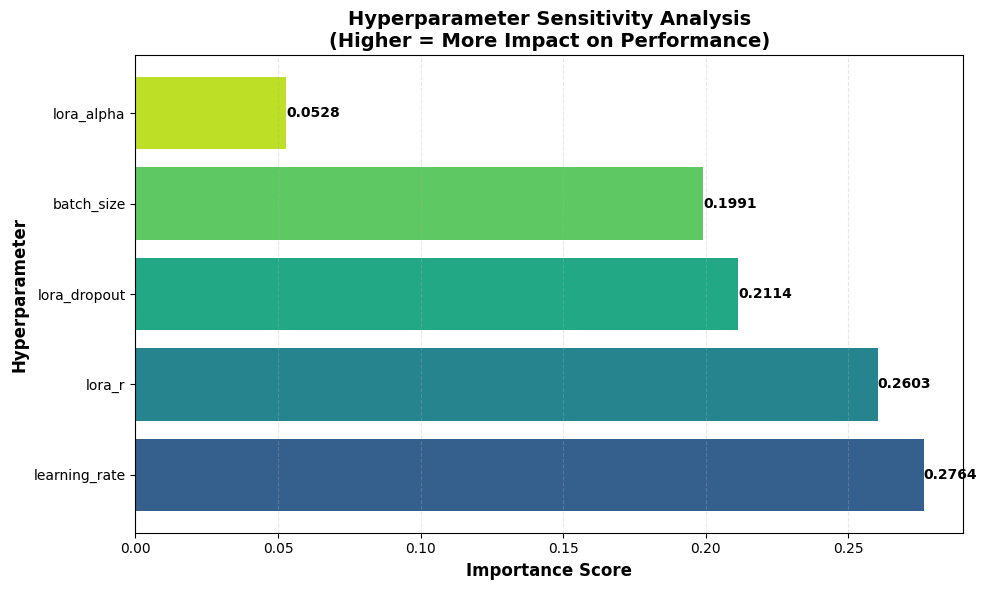


✓ Generating hyperparameter evolution plots...


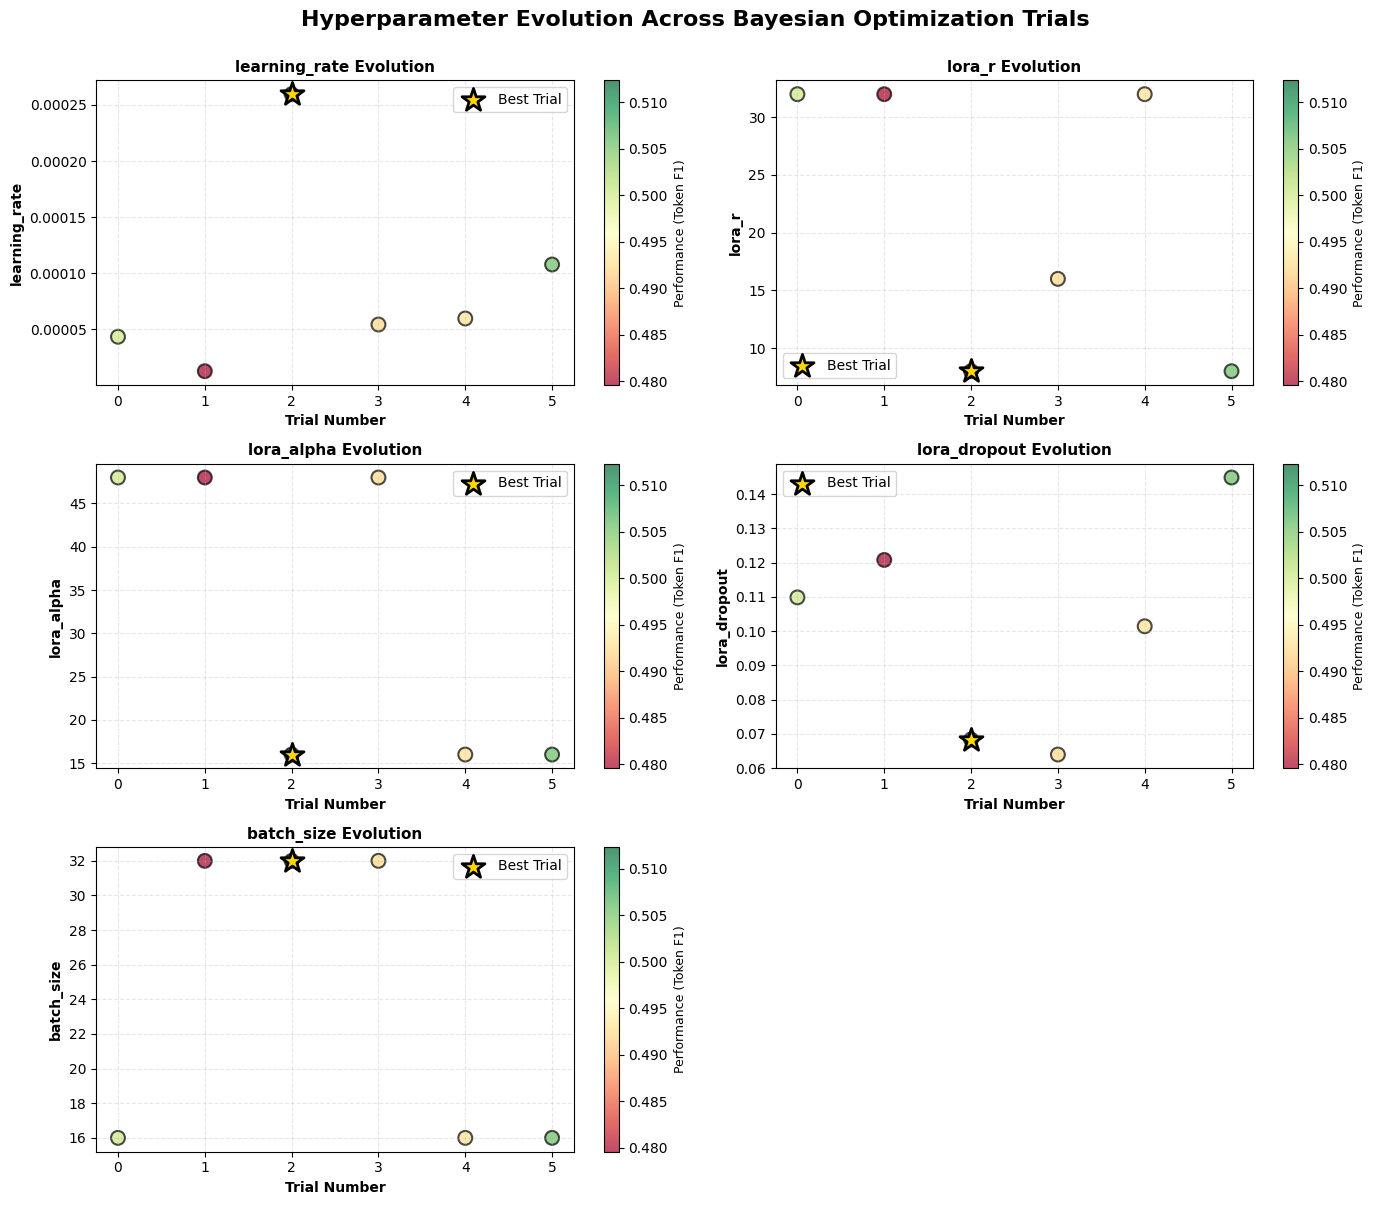

✓ Computing hyperparameter-performance correlations...


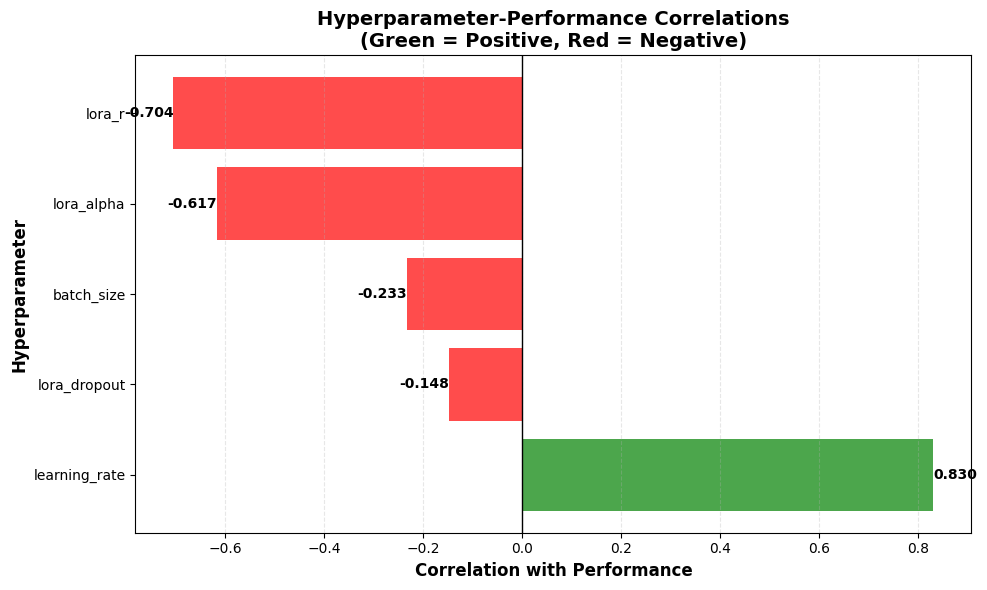


Correlations with Performance:
  • learning_rate       : +0.830 (↑ Positive)
  • lora_dropout        : -0.148 (↓ Negative)
  • batch_size          : -0.233 (↓ Negative)
  • lora_alpha          : -0.617 (↓ Negative)
  • lora_r              : -0.704 (↓ Negative)

✓ Generating parallel coordinates visualization...


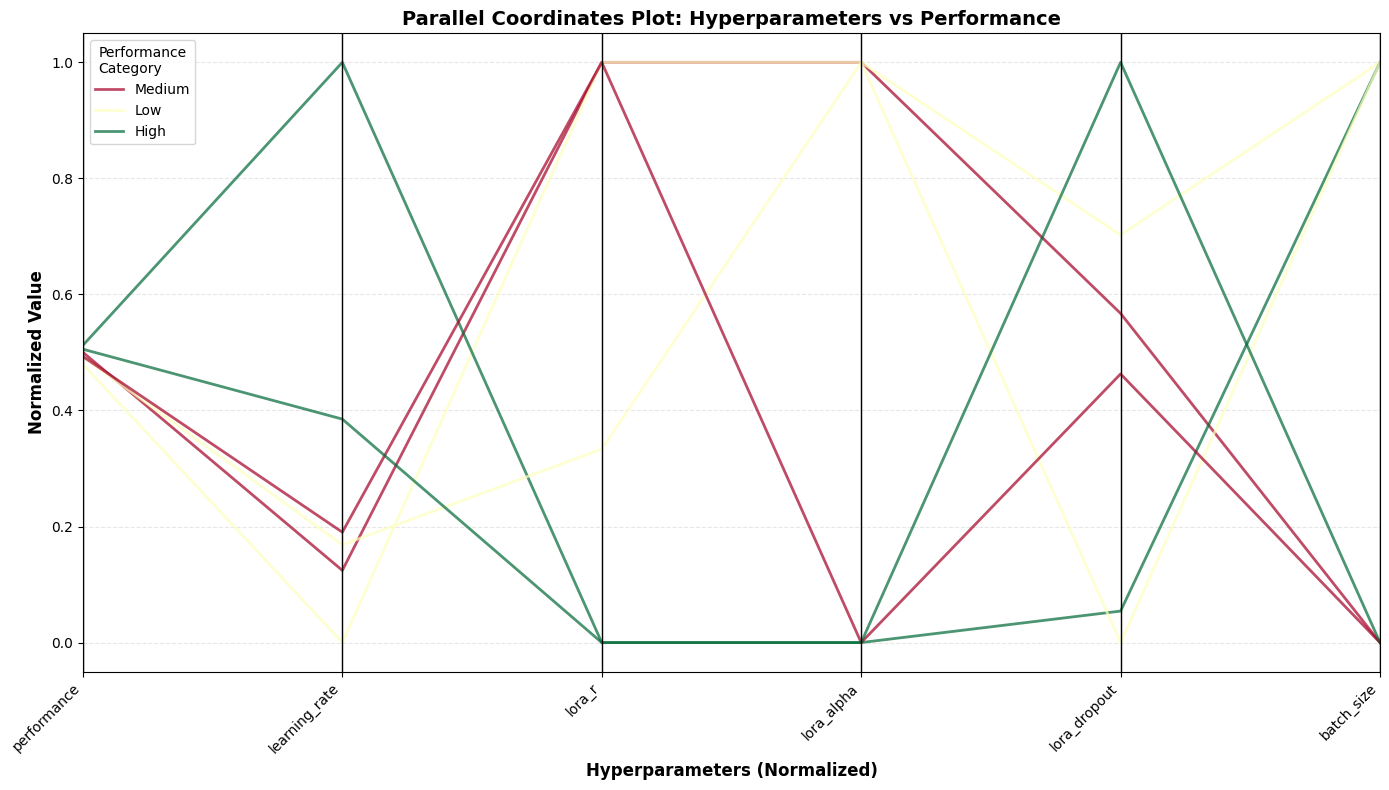


✓ Sensitivity analysis complete!



In [ ]:
print(f"\n{'='*60}")
print("COMPREHENSIVE HYPERPARAMETER SENSITIVITY ANALYSIS")
print(f"{'='*60}\n")

# 1. Compute and plot importance
try:
    importance = get_param_importances(study)
    importance_sorted = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True))

    print("Hyperparameter Importance Scores:")
    print("(Higher = More impact on performance)\n")
    for param, score in importance_sorted.items():
        print(f"  • {param:20s}: {score:.4f}")

    # Save importance
    importance_df = pd.DataFrame([
        {'hyperparameter': k, 'importance_score': v}
        for k, v in importance_sorted.items()
    ])
    importance_df.to_csv(os.path.join(PLOTS_DIR, 'hyperparameter_importance.csv'), index=False)

    with open(os.path.join(BAYESIAN_OUTPUT_DIR, "hyperparameter_importance.json"), "w") as f:
        json.dump(importance_sorted, f, indent=2)

    # Plot importance
    plot_hyperparameter_importance(
        importance_sorted,
        os.path.join(PLOTS_DIR, 'hyperparameter_importance.png')
    )

except Exception as e:
    print(f"Could not compute importance: {e}")
    importance_sorted = {}

# 2. Plot hyperparameter evolution
print("\n✓ Generating hyperparameter evolution plots...")
plot_hyperparameter_history(
    study,
    os.path.join(PLOTS_DIR, 'hyperparameter_evolution.png')
)

# 3. Plot correlations
print("✓ Computing hyperparameter-performance correlations...")
correlations = plot_hyperparameter_correlations(
    study,
    os.path.join(PLOTS_DIR, 'hyperparameter_correlations.png')
)

print("\nCorrelations with Performance:")
for param, corr in correlations.items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    print(f"  • {param:20s}: {corr:+.3f} ({direction})")

# Save correlations
correlations_df = pd.DataFrame({
    'hyperparameter': correlations.index,
    'correlation': correlations.values
})
correlations_df.to_csv(os.path.join(PLOTS_DIR, 'hyperparameter_correlations.csv'), index=False)

# 4. Parallel coordinates
print("\n✓ Generating parallel coordinates visualization...")
plot_parallel_coordinates(
    study,
    os.path.join(PLOTS_DIR, 'parallel_coordinates.png')
)

print(f"\n{'='*60}")
print("✓ Sensitivity analysis complete!")
print(f"{'='*60}\n")

🎯 Cell 16: Sensitivity Analysis Insights

In [ ]:
print(f"\n{'='*60}")
print("SENSITIVITY ANALYSIS INSIGHTS")
print(f"{'='*60}\n")

# Best vs Worst comparison
best_trial = study.best_trial
worst_trial = min(study.trials, key=lambda t: t.value)

print("Best vs Worst Trial Comparison:\n")

print(f"🏆 Best Trial #{best_trial.number}:")
print(f"   Performance: {best_trial.value:.4f}")
print(f"   Hyperparameters:")
for k, v in best_trial.params.items():
    print(f"     • {k}: {v}")

print(f"\n💔 Worst Trial #{worst_trial.number}:")
print(f"   Performance: {worst_trial.value:.4f}")
print(f"   Hyperparameters:")
for k, v in worst_trial.params.items():
    print(f"     • {k}: {v}")

perf_gap = best_trial.value - worst_trial.value
rel_improvement = (best_trial.value / worst_trial.value - 1) * 100

print(f"\n📊 Performance Gap: {perf_gap:.4f}")
print(f"📈 Relative Improvement: {rel_improvement:.2f}%")

# Key insights
if importance_sorted:
    print(f"\n{'='*60}")
    print("KEY INSIGHTS")
    print(f"{'='*60}\n")

    most_important = list(importance_sorted.keys())[0]
    least_important = list(importance_sorted.keys())[-1]

    print(f"🔥 Most Important: {most_important}")
    print(f"   Impact Score: {importance_sorted[most_important]:.4f}")
    print(f"   Best Value: {best_trial.params[most_important]}")
    print(f"   💡 Focus on tuning this parameter\n")

    print(f"❄️  Least Important: {least_important}")
    print(f"   Impact Score: {importance_sorted[least_important]:.4f}")
    print(f"   Best Value: {best_trial.params[least_important]}")
    print(f"   💡 Can use fixed value\n")

# Save complete report
sensitivity_report = {
    "hyperparameter_importance": importance_sorted,
    "hyperparameter_correlations": correlations.to_dict(),
    "best_trial": {
        "number": best_trial.number,
        "performance": best_trial.value,
        "params": best_trial.params
    },
    "worst_trial": {
        "number": worst_trial.number,
        "performance": worst_trial.value,
        "params": worst_trial.params
    },
    "performance_gap": perf_gap,
    "relative_improvement_pct": rel_improvement,
    "all_trials_summary": [
        {"trial": t.number, "performance": t.value, "params": t.params}
        for t in study.trials
    ]
}

with open(os.path.join(BAYESIAN_OUTPUT_DIR, "sensitivity_analysis_report.json"), "w") as f:
    json.dump(sensitivity_report, f, indent=2)

print(f"✓ Complete sensitivity report saved!")


SENSITIVITY ANALYSIS INSIGHTS

Best vs Worst Trial Comparison:

🏆 Best Trial #2:
   Performance: 0.5123
   Hyperparameters:
     • learning_rate: 0.00025959425503112657
     • lora_r: 8
     • lora_alpha: 16
     • lora_dropout: 0.06834045098534339
     • batch_size: 32

💔 Worst Trial #1:
   Performance: 0.4796
   Hyperparameters:
     • learning_rate: 1.2551115172973821e-05
     • lora_r: 32
     • lora_alpha: 48
     • lora_dropout: 0.12080725777960455
     • batch_size: 32

📊 Performance Gap: 0.0328
📈 Relative Improvement: 6.83%

KEY INSIGHTS

🔥 Most Important: learning_rate
   Impact Score: 0.2764
   Best Value: 0.00025959425503112657
   💡 Focus on tuning this parameter

❄️  Least Important: lora_alpha
   Impact Score: 0.0528
   Best Value: 16
   💡 Can use fixed value

✓ Complete sensitivity report saved!


🔮 Cell 17: Load Best Model for Inference

In [ ]:
# Enable optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print("Loading best model for inference...")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_DIR)
base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True
)
base_model.to(device)
base_model.eval()

model = PeftModel.from_pretrained(base_model, BEST_MODEL_DIR)
model.to(device)
model.eval()

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

print("✓ Best model loaded successfully!")

Loading best model for inference...
✓ Best model loaded successfully!


🧪 Cell 18: Run Inference on Test Set

In [ ]:
# Load test data
df_test = pd.read_csv(TEST_DATA_PATH)
print(f"Loaded {len(df_test)} test samples")

df_test_sample = df_test.copy()
gold_sql = df_test_sample["sql"].tolist()
gold_complexity = df_test_sample["sql_complexity"].tolist() if "sql_complexity" in df_test_sample.columns else None

dataset_new = Dataset.from_pandas(df_test_sample)

# Preprocess
def preprocess_inference(batch):
    inputs = batch["input_text"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)
    return model_inputs

tokenized_new = dataset_new.map(preprocess_inference, batched=True, remove_columns=["input_text"])

# Generation config
gen_config = GenerationConfig.from_model_config(model.config)
gen_config.num_beams = 1
gen_config.max_new_tokens = 128
gen_config.do_sample = False
gen_config.pad_token_id = tokenizer.pad_token_id

# Run inference
predictions = []
batch_size = 64

print("\nRunning inference on test set...")
start_time = time.time()

for i in range(0, len(tokenized_new), batch_size):
    end_i = min(i + batch_size, len(tokenized_new))

    batch_dict = {}
    for col in tokenized_new.column_names:
        if col not in ["sql", "sql_complexity"]:
            batch_dict[col] = tokenized_new[col][i:end_i]

    features = [
        {col: batch_dict[col][j] for col in batch_dict}
        for j in range(len(batch_dict[list(batch_dict.keys())[0]]))
    ]
    batch = data_collator(features)

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=gen_config
        )

    gen_sql = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions.extend([
        sql.split(tokenizer.eos_token)[0] if tokenizer.eos_token else sql
        for sql in gen_sql
    ])

    if (i // batch_size + 1) % 10 == 0:
        elapsed = time.time() - start_time
        pct = (end_i/len(tokenized_new))*100
        print(f"  Processed {end_i}/{len(tokenized_new)} ({pct:.1f}%) - {elapsed:.1f}s")

end_time = time.time()
print(f"\n✓ Inference complete in {end_time - start_time:.1f}s")

Loaded 5649 test samples


Map:   0%|          | 0/5649 [00:00<?, ? examples/s]


Running inference on test set...
  Processed 640/5649 (11.3%) - 73.7s
  Processed 1280/5649 (22.7%) - 147.4s
  Processed 1920/5649 (34.0%) - 221.1s
  Processed 2560/5649 (45.3%) - 294.7s
  Processed 3200/5649 (56.6%) - 368.7s
  Processed 3840/5649 (68.0%) - 442.3s
  Processed 4480/5649 (79.3%) - 515.7s
  Processed 5120/5649 (90.6%) - 589.3s

✓ Inference complete in 652.8s


📊 Cell 19: Compute Test Metrics (with ROUGE)


Computing test metrics...
Computing ROUGE scores...

TEST SET RESULTS (5649 samples)
Exact Match:        0.0621
Token F1:           0.6923

ROUGE-2 Scores:
  Precision:        0.4823
  Recall:           0.4788
  F-measure:        0.4573

ROUGE-L Scores:
  Precision:        0.6426
  Recall:           0.6233
  F-measure:        0.6007



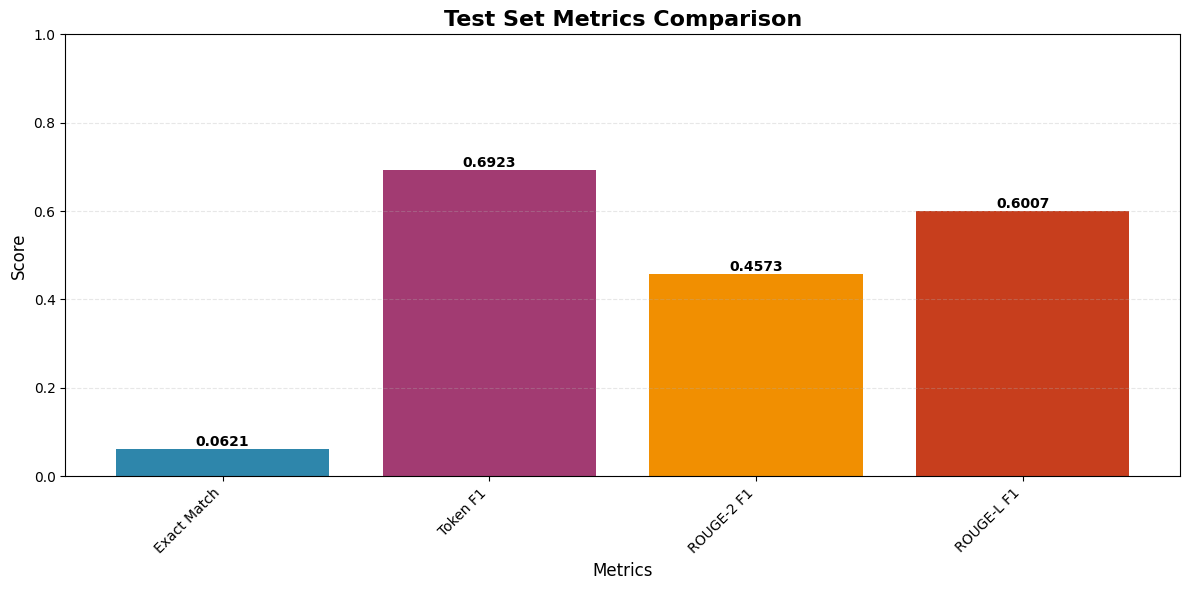

✓ Test metrics computed and saved!


In [ ]:
print("\nComputing test metrics...")

# Basic metrics
exact_scores = [compute_exact_match(p, g) for p, g in zip(predictions, gold_sql)]
f1_scores = [compute_f1(p, g) for p, g in zip(predictions, gold_sql)]

# ROUGE scores
print("Computing ROUGE scores...")
rouge_scores = [compute_rouge_scores(p, g) for p, g in zip(predictions, gold_sql)]

# Aggregate metrics
exact_match = np.mean(exact_scores)
token_f1 = np.mean(f1_scores)
rouge2_precision = np.mean([s['rouge2_precision'] for s in rouge_scores])
rouge2_recall = np.mean([s['rouge2_recall'] for s in rouge_scores])
rouge2_fmeasure = np.mean([s['rouge2_fmeasure'] for s in rouge_scores])
rougeL_precision = np.mean([s['rougeL_precision'] for s in rouge_scores])
rougeL_recall = np.mean([s['rougeL_recall'] for s in rouge_scores])
rougeL_fmeasure = np.mean([s['rougeL_fmeasure'] for s in rouge_scores])

print(f"\n{'='*60}")
print(f"TEST SET RESULTS ({len(predictions)} samples)")
print(f"{'='*60}")
print(f"Exact Match:        {exact_match:.4f}")
print(f"Token F1:           {token_f1:.4f}")
print(f"\nROUGE-2 Scores:")
print(f"  Precision:        {rouge2_precision:.4f}")
print(f"  Recall:           {rouge2_recall:.4f}")
print(f"  F-measure:        {rouge2_fmeasure:.4f}")
print(f"\nROUGE-L Scores:")
print(f"  Precision:        {rougeL_precision:.4f}")
print(f"  Recall:           {rougeL_recall:.4f}")
print(f"  F-measure:        {rougeL_fmeasure:.4f}")
print(f"{'='*60}\n")

# Save metrics
test_metrics = {
    "exact_match": float(exact_match),
    "token_f1": float(token_f1),
    "rouge2_precision": float(rouge2_precision),
    "rouge2_recall": float(rouge2_recall),
    "rouge2_fmeasure": float(rouge2_fmeasure),
    "rougeL_precision": float(rougeL_precision),
    "rougeL_recall": float(rougeL_recall),
    "rougeL_fmeasure": float(rougeL_fmeasure),
}

with open(os.path.join(BEST_MODEL_DIR, "test_metrics.json"), "w") as f:
    json.dump(test_metrics, f, indent=2)

# Plot metrics comparison
metrics_dict = {
    'Exact Match': exact_match,
    'Token F1': token_f1,
    'ROUGE-2 F1': rouge2_fmeasure,
    'ROUGE-L F1': rougeL_fmeasure
}
plot_metrics_comparison(
    metrics_dict,
    'Test Set Metrics Comparison',
    os.path.join(PLOTS_DIR, 'test_metrics_comparison.png')
)

print("✓ Test metrics computed and saved!")

🎯 Cell 20: SQL Complexity Classification


BIAS ANALYSIS WITH CONFUSION MATRIX

Distribution of SQL complexity in test set:
                  count  percentage
sql_complexity                     
basic SQL          2685       47.53
aggregation        1304       23.08
single join         884       15.65
subqueries          374        6.62
window functions    196        3.47
multiple_joins      139        2.46
set operations       50        0.89
CTEs                 17        0.30


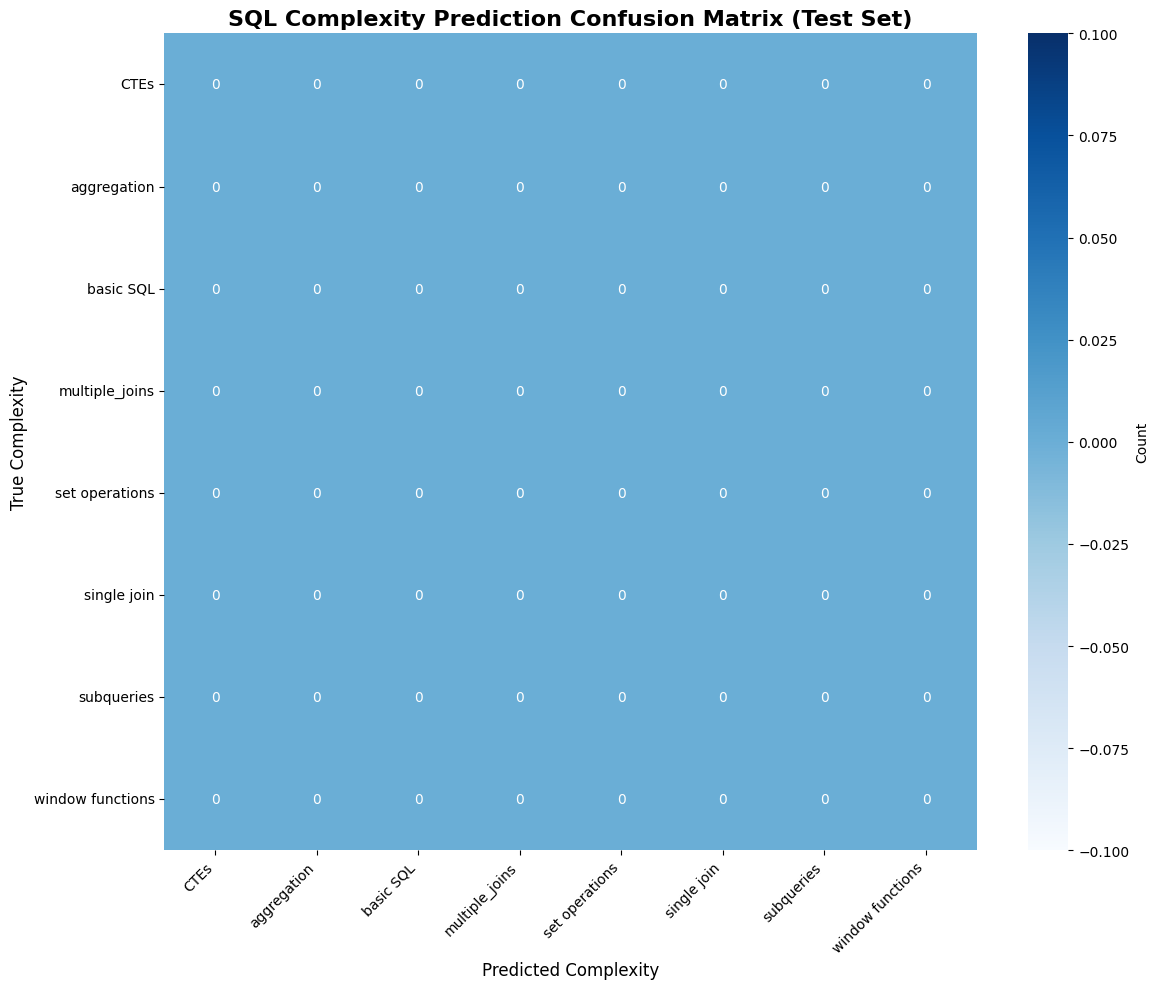


Classification Report for SQL Complexity Prediction Confusion Matrix (Test Set):
                  precision    recall  f1-score   support

            CTEs       0.00      0.00      0.00      17.0
     aggregation       0.00      0.00      0.00    1304.0
       basic SQL       0.00      0.00      0.00    2685.0
  multiple_joins       0.00      0.00      0.00     139.0
  set operations       0.00      0.00      0.00      50.0
     single join       0.00      0.00      0.00     884.0
      subqueries       0.00      0.00      0.00     374.0
window functions       0.00      0.00      0.00     196.0

       micro avg       0.00      0.00      0.00    5649.0
       macro avg       0.00      0.00      0.00    5649.0
    weighted avg       0.00      0.00      0.00    5649.0


Per-Complexity Performance Metrics
                 exact_match       token_f1       rouge2_fmeasure        \
                        mean count     mean count            mean count   
sql_complexity                   

In [ ]:
#  per-complexity bias analysis

if gold_complexity:
    print("\n" + "="*60)
    print("BIAS ANALYSIS: MODEL PERFORMANCE BY SQL COMPLEXITY")
    print("="*60 + "\n")

    # Create evaluation dataframe
    df_test_sample_reset = df_test_sample.reset_index(drop=True)
    df_eval = df_test_sample_reset.copy()
    df_eval["pred_sql"] = predictions
    df_eval["exact_match"] = exact_scores
    df_eval["token_f1"] = f1_scores
    df_eval["rouge2_fmeasure"] = [s['rouge2_fmeasure'] for s in rouge_scores]
    df_eval["rougeL_fmeasure"] = [s['rougeL_fmeasure'] for s in rouge_scores]

    # Distribution
    print("📊 SQL Complexity Distribution in Test Set:")
    complexity_dist = df_eval["sql_complexity"].value_counts().sort_index()
    print(complexity_dist)
    print(f"\nTotal samples: {len(df_eval)}")

    # Per-complexity performance - MAIN BIAS ANALYSIS
    print(f"\n{'='*60}")
    print("🔍 BIAS ANALYSIS: Performance by Complexity Level")
    print(f"{'='*60}\n")

    per_complexity = (
        df_eval
        .groupby("sql_complexity")[[
            "exact_match", "token_f1",
            "rouge2_fmeasure", "rougeL_fmeasure"
        ]]
        .agg(["mean", "std", "count"])
        .round(4)
    )

    print(per_complexity)

    # Flatten column names for easier reading
    per_complexity_flat = df_eval.groupby("sql_complexity").agg({
        "exact_match": ["mean", "std", "count"],
        "token_f1": ["mean", "std"],
        "rouge2_fmeasure": ["mean", "std"],
        "rougeL_fmeasure": ["mean", "std"]
    }).round(4)

    # Save to CSV
    per_complexity_flat.to_csv(
        os.path.join(PLOTS_DIR, 'per_complexity_metrics_test.csv')
    )
    print(f"\n✓ Saved to: {PLOTS_DIR}/per_complexity_metrics_test.csv")

    # Identify bias/performance gaps
    print(f"\n{'='*60}")
    print("⚠️  BIAS DETECTION: Performance Gaps")
    print(f"{'='*60}\n")

    token_f1_by_complexity = df_eval.groupby("sql_complexity")["token_f1"].mean()
    max_f1 = token_f1_by_complexity.max()
    min_f1 = token_f1_by_complexity.min()
    gap = max_f1 - min_f1

    print(f"Token F1 Performance Range:")
    print(f"  Best:     {token_f1_by_complexity.idxmax():20s} = {max_f1:.4f}")
    print(f"  Worst:    {token_f1_by_complexity.idxmin():20s} = {min_f1:.4f}")
    print(f"  Gap:      {gap:.4f} ({(gap/max_f1)*100:.1f}% relative difference)")

    # Per-complexity breakdown
    print(f"\nDetailed Breakdown:")
    for complexity in sorted(df_eval["sql_complexity"].unique()):
        subset = df_eval[df_eval["sql_complexity"] == complexity]
        f1 = subset["token_f1"].mean()
        count = len(subset)
        pct = (count / len(df_eval)) * 100
        print(f"  {complexity:20s}: F1={f1:.4f} | n={count:4d} ({pct:5.1f}%)")

    # Mitigation suggestions
    if gap > 0.15:  # If gap > 15%
        print(f"\n💡 MITIGATION RECOMMENDATIONS:")
        print(f"   High bias detected (gap > 15%)")
        print(f"   Consider:")
        print(f"   - Adding more training data for underperforming complexity levels")
        print(f"   - Using weighted loss to focus on underperforming classes")
        print(f"   - Fine-tuning LoRA rank/alpha for complex queries")

    # Plot complexity performance
    plot_complexity_performance(
        df_eval,
        os.path.join(PLOTS_DIR, 'complexity_performance_test.png')
    )
    print(f"\n✓ Complexity performance plot saved!")

else:
    print("\n⚠️  No complexity information available in test set")

✅ Cell 21: Syntax Validation


SYNTAX VALIDATION

Overall Syntax Validity:
  Executable: 0.8010 (80.1%)

Syntax Validity by SQL Complexity:
                    mean  count
sql_complexity                 
CTEs              0.9412     17
basic SQL         0.8845   2685
set operations    0.8000     50
multiple_joins    0.7914    139
subqueries        0.7620    374
aggregation       0.7201   1304
window functions  0.7194    196
single join       0.7002    884


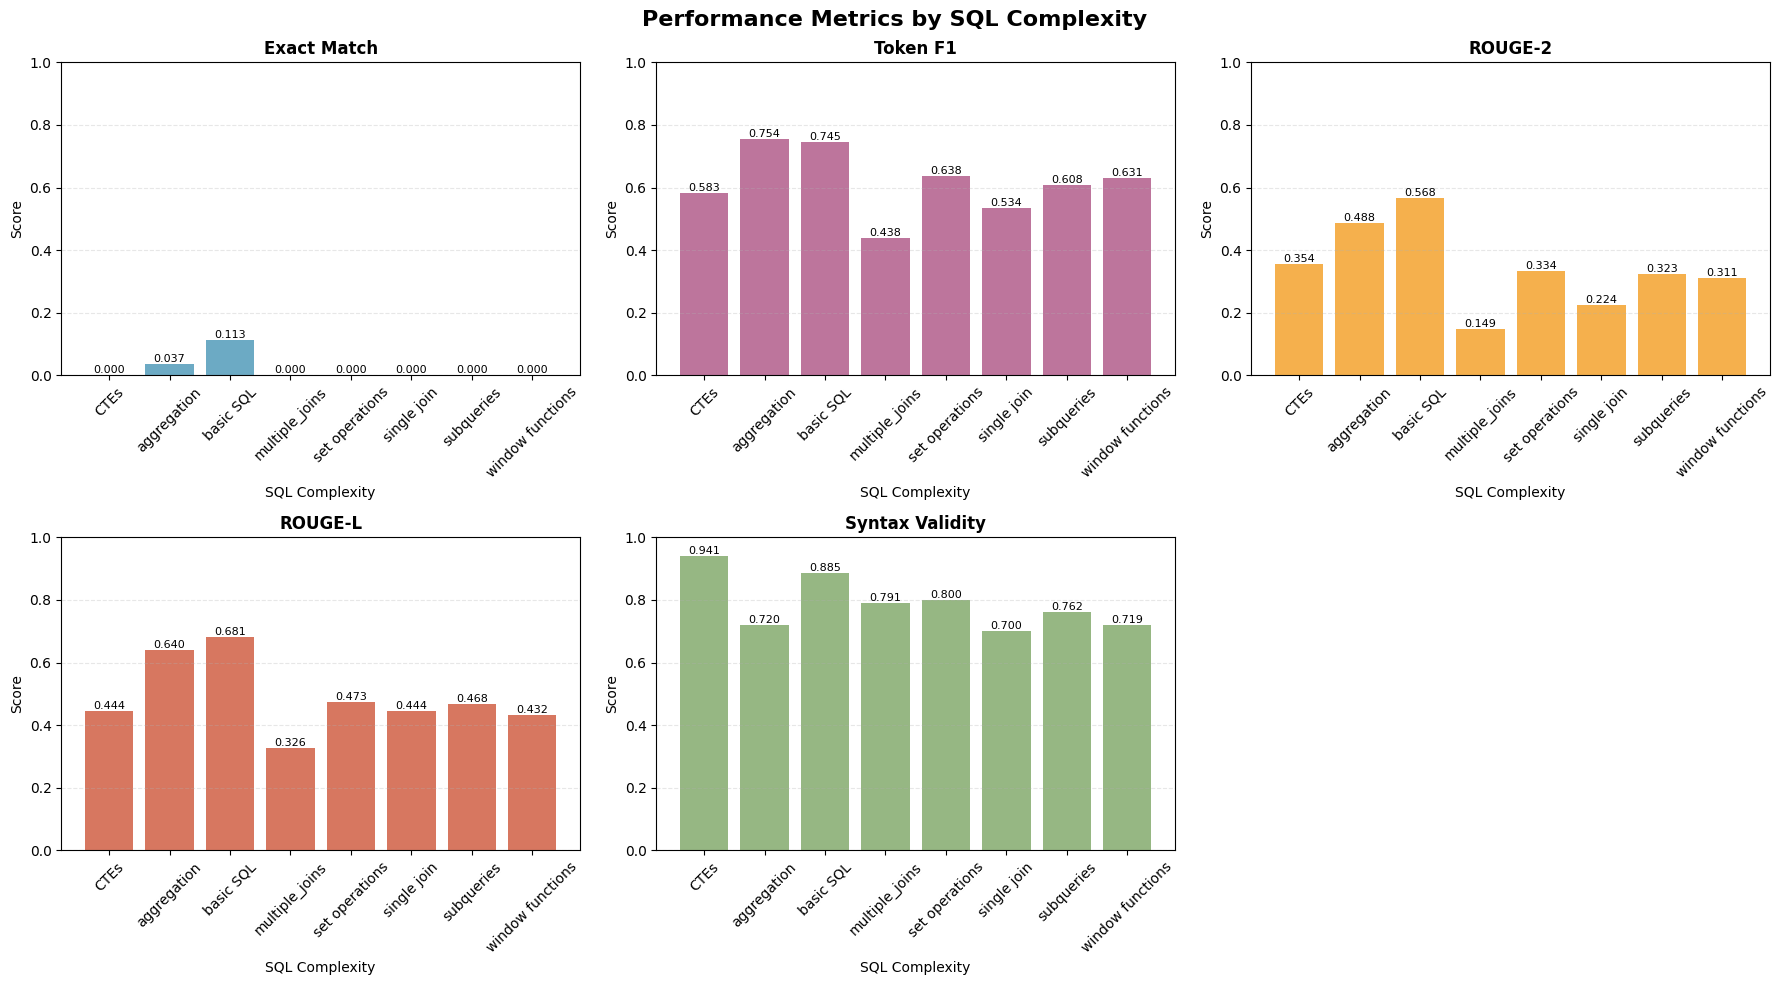


✓ Complexity performance plot saved!


In [ ]:
def is_executable_sql(sql_str, dialect='mysql'):
    """Check if SQL is syntactically valid"""
    try:
        parsed = parse_one(sql_str, dialect=dialect)
        return 1.0
    except Exception:
        return 0.0

print("\n" + "="*60)
print("SYNTAX VALIDATION")
print("="*60)

# Overall validity
valid_syntax_scores = [is_executable_sql(p) for p in predictions]
syntax_validity = np.mean(valid_syntax_scores)

print(f"\nOverall Syntax Validity:")
print(f"  Executable: {syntax_validity:.4f} ({syntax_validity*100:.1f}%)")

# Per-complexity validity
if gold_complexity:
    df_eval["valid_syntax"] = valid_syntax_scores
    per_complexity_valid = (
        df_eval.groupby("sql_complexity")["valid_syntax"]
        .agg(["mean", "count"])
        .round(4)
        .sort_values("mean", ascending=False)
    )

    print(f"\nSyntax Validity by SQL Complexity:")
    print(per_complexity_valid)

    # Plot complexity performance
    plot_complexity_performance(
        df_eval,
        os.path.join(PLOTS_DIR, 'complexity_performance_test.png')
    )

    print(f"\n✓ Complexity performance plot saved!")

🔍 Cell 22: Sample Predictions

In [ ]:
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60 + "\n")

df_test_sample_reset = df_test_sample.reset_index(drop=True)

for i in range(min(5, len(predictions))):
    print(f"Sample {i+1}:")
    print(f"  Input:       {df_test_sample_reset.iloc[i]['input_text'][:80]}...")
    print(f"  Prediction:  {predictions[i]}")
    print(f"  Gold:        {gold_sql[i]}")

    if gold_complexity:
        print(f"  Complexity:  {gold_complexity[i]}")

    print(f"  Exact Match: {exact_scores[i]:.2f}")
    print(f"  Token F1:    {f1_scores[i]:.4f}")
    print(f"  ROUGE-2:     {rouge_scores[i]['rouge2_fmeasure']:.4f}")
    print(f"  ROUGE-L:     {rouge_scores[i]['rougeL_fmeasure']:.4f}")
    print("-" * 60)


SAMPLE PREDICTIONS

Sample 1:
  Input:       context: CREATE TABLE creative_ai (application_id INT, name TEXT, region TEXT, e...
  Prediction:  SELECT avg(explainability_score) FROM creative_ai WHERE region = 'Europe' AND region = 'North America';
  Gold:        SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');
  Complexity:  basic SQL
  Exact Match: 0.00
  Token F1:    0.8667
  ROUGE-2:     0.7200
  ROUGE-L:     0.8889
------------------------------------------------------------
Sample 2:
  Input:       context: CREATE TABLE rural_infrastructure (id INT, project_name TEXT, sector TE...
  Prediction:  SELECT project_name, completion_date FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date  2010 FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date  2010;
  Gold:        DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';
  Complexity:  basic SQL
  Exact Ma

🔬 Cell 23: Validation Set Analysis

In [ ]:
print("\n" + "="*60)
print("VALIDATION SET ANALYSIS")
print("="*60 + "\n")

# Load validation data
df_val_full = pd.read_csv(VAL_DATA_PATH)
df_val_analysis = df_val_full.sample(n=min(20000, len(df_val_full)), random_state=42)
print(f"Analyzing {len(df_val_analysis)} validation samples")

gold_sql_val = df_val_analysis["sql"].tolist()
gold_complexity_val = df_val_analysis["sql_complexity"].tolist() if "sql_complexity" in df_val_analysis.columns else None

dataset_val_new = Dataset.from_pandas(df_val_analysis)
tokenized_val_new = dataset_val_new.map(preprocess_inference, batched=True, remove_columns=["input_text"])

# Run inference
predictions_val = []
batch_size_val = 64

print("Running inference on validation set...")
start_time_val = time.time()

for i in range(0, len(tokenized_val_new), batch_size_val):
    end_i = min(i + batch_size_val, len(tokenized_val_new))

    batch_dict = {}
    for col in tokenized_val_new.column_names:
        if col not in ["sql", "sql_complexity"]:
            batch_dict[col] = tokenized_val_new[col][i:end_i]

    features = [
        {col: batch_dict[col][j] for col in batch_dict}
        for j in range(len(batch_dict[list(batch_dict.keys())[0]]))
    ]
    batch = data_collator(features)

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=gen_config
        )

    gen_sql = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    predictions_val.extend([
        sql.split(tokenizer.eos_token)[0] if tokenizer.eos_token else sql
        for sql in gen_sql
    ])

    if (i // batch_size_val + 1) % 10 == 0:
        elapsed = time.time() - start_time_val
        print(f"  Processed {end_i}/{len(tokenized_val_new)} - {elapsed:.1f}s")

end_time_val = time.time()
print(f"✓ Validation inference complete in {end_time_val - start_time_val:.1f}s\n")


VALIDATION SET ANALYSIS

Analyzing 20000 validation samples


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Running inference on validation set...
  Processed 640/20000 - 74.0s
  Processed 1280/20000 - 147.5s
  Processed 1920/20000 - 220.8s
  Processed 2560/20000 - 294.1s
  Processed 3200/20000 - 367.8s
  Processed 3840/20000 - 441.6s
  Processed 4480/20000 - 515.3s
  Processed 5120/20000 - 588.8s
  Processed 5760/20000 - 662.7s
  Processed 6400/20000 - 736.8s
  Processed 7040/20000 - 810.9s
  Processed 7680/20000 - 884.7s
  Processed 8320/20000 - 958.2s
  Processed 8960/20000 - 1031.7s
  Processed 9600/20000 - 1105.5s
  Processed 10240/20000 - 1178.6s
  Processed 10880/20000 - 1252.0s
  Processed 11520/20000 - 1325.1s
  Processed 12160/20000 - 1398.3s
  Processed 12800/20000 - 1471.6s
  Processed 13440/20000 - 1544.9s
  Processed 14080/20000 - 1618.3s
  Processed 14720/20000 - 1691.3s
  Processed 15360/20000 - 1764.4s
  Processed 16000/20000 - 1837.7s
  Processed 16640/20000 - 1911.0s
  Processed 17280/20000 - 1984.2s
  Processed 17920/20000 - 2057.1s
  Processed 18560/20000 - 2130.3s
  Pro

📊 Cell 24: Validation Metrics

Computing ROUGE scores for validation...

VALIDATION SET RESULTS (20000 samples)
Exact Match:        0.0191
Token F1:           0.5248
ROUGE-2 F1:         0.2742
ROUGE-L F1:         0.4128



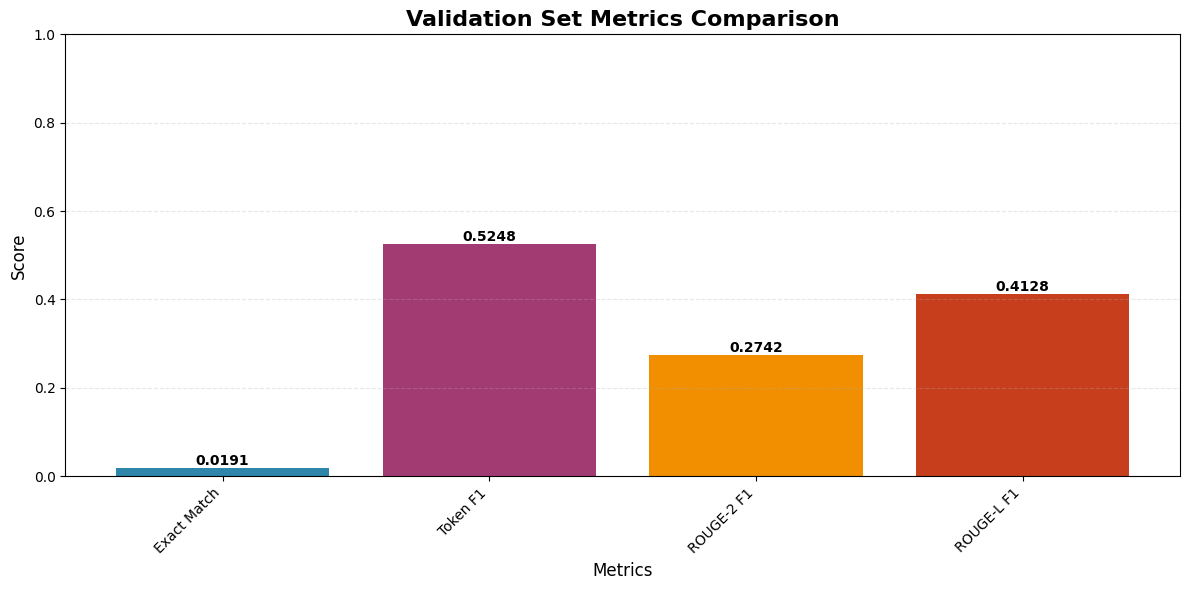

Validation Syntax Validity: 0.7656 (76.6%)



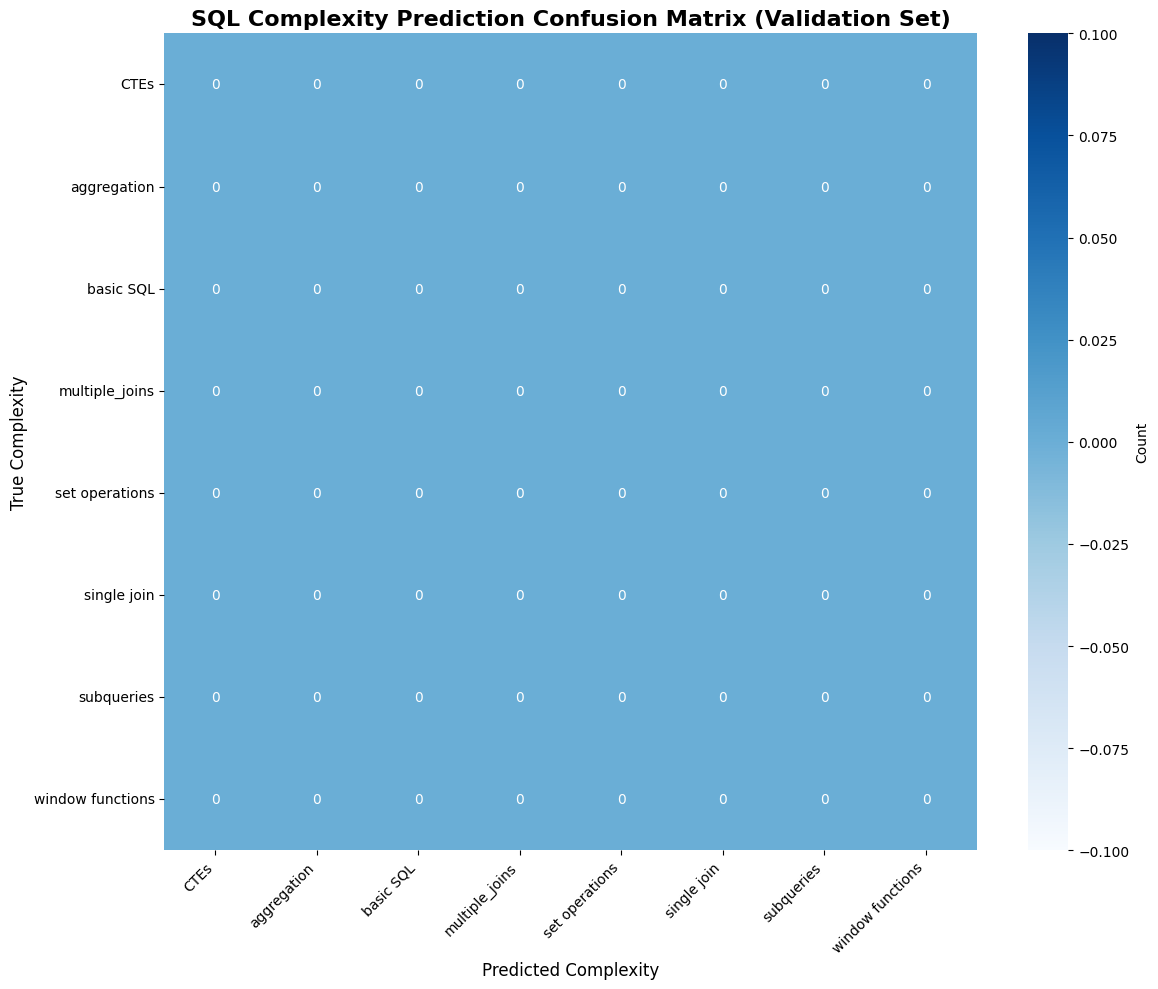


Classification Report for SQL Complexity Prediction Confusion Matrix (Validation Set):
                  precision    recall  f1-score   support

            CTEs       0.00      0.00      0.00    3009.0
     aggregation       0.00      0.00      0.00    1393.0
       basic SQL       0.00      0.00      0.00    2800.0
  multiple_joins       0.00      0.00      0.00    2944.0
  set operations       0.00      0.00      0.00    3037.0
     single join       0.00      0.00      0.00     920.0
      subqueries       0.00      0.00      0.00    2971.0
window functions       0.00      0.00      0.00    2926.0

       micro avg       0.00      0.00      0.00   20000.0
       macro avg       0.00      0.00      0.00   20000.0
    weighted avg       0.00      0.00      0.00   20000.0

Per-Complexity Performance (Validation):
                 exact_match       token_f1       rouge2_fmeasure        \
                        mean count     mean count            mean count   
sql_complexity        

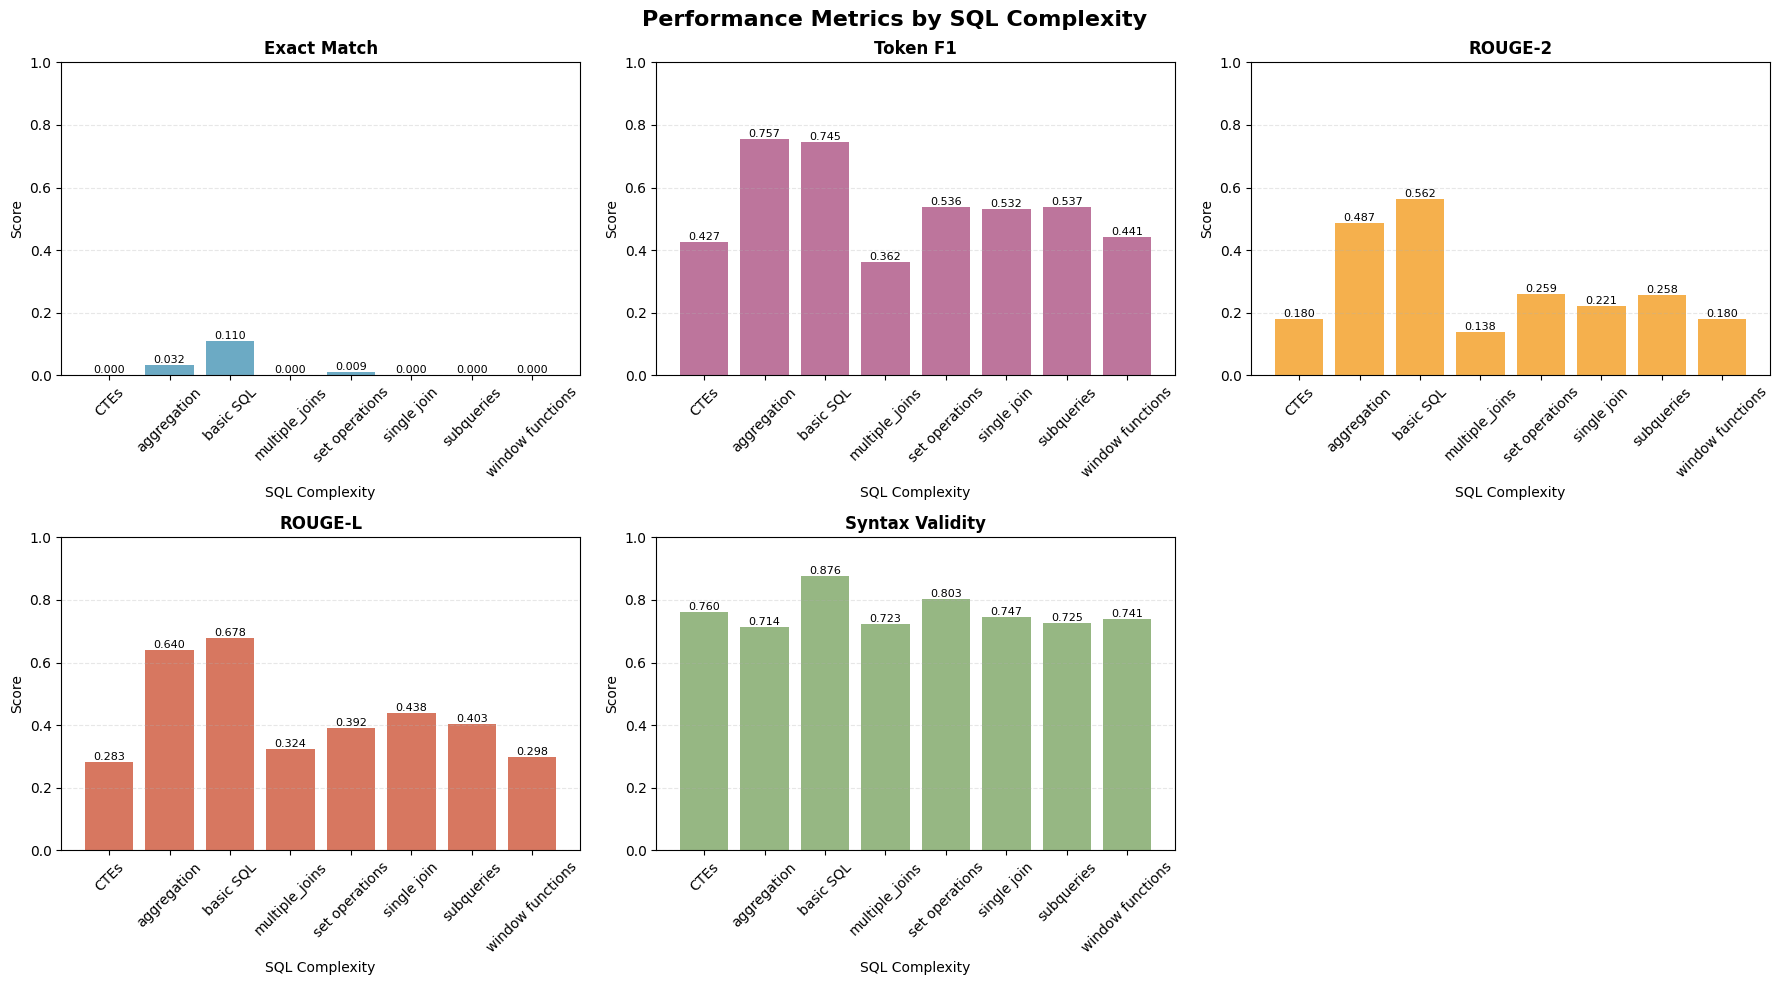


✓ Validation analysis complete!


In [ ]:

# Compute validation metrics
exact_scores_val = [compute_exact_match(p, g) for p, g in zip(predictions_val, gold_sql_val)]
f1_scores_val = [compute_f1(p, g) for p, g in zip(predictions_val, gold_sql_val)]

# ROUGE scores
print("Computing ROUGE scores for validation...")
rouge_scores_val = [compute_rouge_scores(p, g) for p, g in zip(predictions_val, gold_sql_val)]

exact_match_val = np.mean(exact_scores_val)
token_f1_val = np.mean(f1_scores_val)
rouge2_fmeasure_val = np.mean([s['rouge2_fmeasure'] for s in rouge_scores_val])
rougeL_fmeasure_val = np.mean([s['rougeL_fmeasure'] for s in rouge_scores_val])

print(f"\n{'='*60}")
print(f"VALIDATION SET RESULTS ({len(predictions_val)} samples)")
print(f"{'='*60}")
print(f"Exact Match:        {exact_match_val:.4f}")
print(f"Token F1:           {token_f1_val:.4f}")
print(f"ROUGE-2 F1:         {rouge2_fmeasure_val:.4f}")
print(f"ROUGE-L F1:         {rougeL_fmeasure_val:.4f}")
print(f"{'='*60}\n")

# Save validation metrics
val_metrics = {
    "exact_match": float(exact_match_val),
    "token_f1": float(token_f1_val),
    "rouge2_fmeasure": float(rouge2_fmeasure_val),
    "rougeL_fmeasure": float(rougeL_fmeasure_val),
}

with open(os.path.join(BEST_MODEL_DIR, "validation_metrics.json"), "w") as f:
    json.dump(val_metrics, f, indent=2)

# Plot validation metrics
val_metrics_dict = {
    'Exact Match': exact_match_val,
    'Token F1': token_f1_val,
    'ROUGE-2 F1': rouge2_fmeasure_val,
    'ROUGE-L F1': rougeL_fmeasure_val
}
plot_metrics_comparison(
    val_metrics_dict,
    'Validation Set Metrics Comparison',
    os.path.join(PLOTS_DIR, 'validation_metrics_comparison.png')
)

# Syntax validity
valid_syntax_scores_val = [is_executable_sql(p) for p in predictions_val]
syntax_validity_val = np.mean(valid_syntax_scores_val)
print(f"Validation Syntax Validity: {syntax_validity_val:.4f} ({syntax_validity_val*100:.1f}%)\n")

# Bias analysis for validation set
if gold_complexity_val:
    print(f"\n{'='*60}")
    print("BIAS ANALYSIS: Validation Set Performance by Complexity")
    print(f"{'='*60}\n")

    df_val_analysis_reset = df_val_analysis.reset_index(drop=True)
    df_val_analysis_reset["pred_sql"] = predictions_val
    df_val_analysis_reset["exact_match"] = exact_scores_val
    df_val_analysis_reset["token_f1"] = f1_scores_val
    df_val_analysis_reset["rouge2_fmeasure"] = [s['rouge2_fmeasure'] for s in rouge_scores_val]
    df_val_analysis_reset["rougeL_fmeasure"] = [s['rougeL_fmeasure'] for s in rouge_scores_val]
    df_val_analysis_reset["valid_syntax"] = valid_syntax_scores_val

    # Per-complexity performance
    per_complexity_val = (
        df_val_analysis_reset
        .groupby("sql_complexity")[[
            "exact_match", "token_f1",
            "rouge2_fmeasure", "rougeL_fmeasure", "valid_syntax"
        ]]
        .agg(["mean", "std", "count"])
        .round(4)
    )

    print("Per-Complexity Performance (Validation):")
    print(per_complexity_val)

    per_complexity_val.to_csv(
        os.path.join(PLOTS_DIR, 'per_complexity_metrics_validation.csv')
    )
    print(f"\n✓ Saved to: {PLOTS_DIR}/per_complexity_metrics_validation.csv")

    # Detect validation bias
    print(f"\n{'='*60}")
    print("⚠️  BIAS DETECTION: Validation Set Performance Gaps")
    print(f"{'='*60}\n")

    token_f1_val_by_complexity = df_val_analysis_reset.groupby("sql_complexity")["token_f1"].mean()
    max_f1_val = token_f1_val_by_complexity.max()
    min_f1_val = token_f1_val_by_complexity.min()
    gap_val = max_f1_val - min_f1_val

    print(f"Token F1 Performance Range (Validation):")
    print(f"  Best:     {token_f1_val_by_complexity.idxmax():20s} = {max_f1_val:.4f}")
    print(f"  Worst:    {token_f1_val_by_complexity.idxmin():20s} = {min_f1_val:.4f}")
    print(f"  Gap:      {gap_val:.4f} ({(gap_val/max_f1_val)*100:.1f}% relative difference)")

    print(f"\nDetailed Breakdown:")
    for complexity in sorted(df_val_analysis_reset["sql_complexity"].unique()):
        subset = df_val_analysis_reset[df_val_analysis_reset["sql_complexity"] == complexity]
        f1 = subset["token_f1"].mean()
        count = len(subset)
        pct = (count / len(df_val_analysis_reset)) * 100
        print(f"  {complexity:20s}: F1={f1:.4f} | n={count:4d} ({pct:5.1f}%)")

    # Plot complexity performance
    plot_complexity_performance(
        df_val_analysis_reset,
        os.path.join(PLOTS_DIR, 'complexity_performance_validation.png')
    )

    print(f"\n✓ Complexity performance plot saved!")

print("\n✓ Validation analysis complete!")

Feature Importance Analysis via Complexity Slicing

In [ ]:

print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS: SQL Complexity Impact on Performance")
print(f"{'='*70}\n")

print("📊 Methodology: Slicing-based Feature Importance Analysis")
print("   Each 'feature' = a SQL complexity type")
print("   Performance difference = importance of handling that complexity\n")

# Analyze test set
per_complexity_test = df_eval.groupby("sql_complexity").agg({
    "token_f1": ["mean", "std"],
    "exact_match": ["mean"],
    "rouge2_fmeasure": ["mean"],
}).round(4)

per_complexity_test.columns = ["F1_mean", "F1_std", "ExactMatch", "ROUGE2"]
per_complexity_test = per_complexity_test.sort_values("F1_mean", ascending=False)

print("Test Set - Performance by Complexity Type (Importance Ranking):")
print(per_complexity_test)
print()

# Calculate importance scores (difference from baseline)
baseline_f1 = per_complexity_test["F1_mean"].mean()
per_complexity_test["importance"] = (baseline_f1 - per_complexity_test["F1_mean"]) * 100

print("Importance Scores (% below average):")
for complexity, importance in per_complexity_test["importance"].items():
    bar = "█" * int(importance / 2)
    print(f"  {complexity:20s}: {importance:6.1f}% {bar}")

print(f"\nInterpretation:")
print(f"  - Higher importance = model struggles more with this complexity type")
print(f"  - These are the 'features' the model needs to learn better")
print(f"  - Bias mitigation should focus on high-importance types")

# Save importance analysis
importance_analysis = {
    "methodology": "SQL Complexity Slicing - Feature Importance via Performance Gaps",
    "baseline_f1": float(baseline_f1),
    "complexity_importance": per_complexity_test["importance"].to_dict(),
    "recommendation": "Focus training improvements on highest importance complexities"
}

with open(os.path.join(PLOTS_DIR, 'feature_importance_analysis.json'), 'w') as f:
    json.dump(importance_analysis, f, indent=2)

print(f"\n✓ Saved to: {PLOTS_DIR}/feature_importance_analysis.json")